In [1]:
!pip install webdriver_manager

DEPRECATION: Loading egg at /Users/ryanshen/Desktop/opt/anaconda3/lib/python3.11/site-packages/frozendict-2.3.0-py3.10.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [11]:
import os
import re
import time
import numpy as np
import pandas as pd
import gurobipy as gp
import sys
from gurobipy import GRB
from datetime import datetime
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

import seaborn as sns
from matplotlib import pyplot as plt
import xgboost

In [20]:
parameters = {
    'name': 'ElectricityArbitrage',
    'generator_name': 'ADK HUDSON___FALLS',
    'start_date': None,
    'num_periods': 24,
    'num_markets': 1,
    'num_batteries': 8,
    'battery_capacity': 100,
    'charge_loss': 0.95,
    'max_charge': 50,
    'max_discharge': 100,
    
}

# OPTIGUIDE DATA CODE GOES HERE

In [21]:
def extract_date(file_path):
    match = re.match(r'^(\d+)', file_path.split('/')[4])

    return match.group(1)

In [22]:
def get_prices(start_date, generator_name):
    if start_date == None:
        start_date = datetime.today()
        start_date = start_date.strftime("%Y%m%d")

    dates = [start_date]

    driver_path = ChromeDriverManager().install()

    home_dir = os.path.expanduser("~")

    download_directory = os.path.join(home_dir, 'Downloads_CSV')
    chrome_options = webdriver.ChromeOptions()
    prefs = {'download.default_directory': download_directory}
    chrome_options.add_experimental_option('prefs', prefs)

    # Initialize the driver, use try except blocks depending on version of selenium installed
    try:
        # Older selenium version that takes executable path as argument
        driver = webdriver.Chrome(executable_path=driver_path, options=chrome_options)
    except:
        try:
            # For selenium version 3.141.0 or above
            driver=webdriver.Chrome(options=chrome_options)
        except:
            sys.exit("Please install correct version of selenium")

    driver.get('http://mis.nyiso.com/public/P-2Blist.htm')
    all_links = driver.find_elements("xpath", "//a[@href]")

    if not os.path.exists(download_directory):
        os.makedirs(download_directory)

    for date in dates:
        for link in all_links:
            href = link.get_attribute('href')

            if ('csv' in href) and (date in href):
                link.click()
                time.sleep(2)
                break

    csv_files = [file for file in os.listdir(download_directory) if file.endswith('.csv')]
    prices_by_date = {}

    for file_name in csv_files:
        file_path = os.path.join(download_directory, file_name)
        date = extract_date(file_path)
        df = pd.read_csv(file_path)
        prices = df[df['Name'] == generator_name][['LBMP ($/MWHr)']].values.tolist()

        prices_by_date[date] = prices

    driver.quit()

    return prices_by_date

In [23]:
def plot_solutions(buy, sell, num_periods, num_markets):
    
    buys = [buy[p,i].x for p in range(num_periods) for i in range(num_markets)]
    sells = [sell[p,i].x for p in range(num_periods) for i in range(num_markets)]
    #generating labels
    buy_label = ['Buy' for _ in range(num_periods)] 
    sell_label = ['Sell' for _ in range(num_periods)]
    
    hours = list(range(num_periods))
    hours = ['{}:00'.format(h) for h in hours]
    
    buy_df = pd.DataFrame({'Hour': hours, 'Price in $': buys, 'Decision': buy_label})
    sells_df = pd.DataFrame({'Hour': hours, 'Price in $': sells, 'Decision': sell_label})
    #concatenating buy and sell dataframes for graphing
    df = pd.concat([buy_df, sells_df])
    fig,ax = plt.subplots(figsize=(10,10))
    sns.barplot(df,x='Hour', y = 'Price in $', hue = 'Decision', width = 0.35, ax=ax)
    plt.title('Total Purchased')
    plt.xticks(rotation=90)
    plt.show()

In [24]:
def create_model(parameters): # num_markets is going to be 1 for the time being
    name = parameters['name']
    generator_name = parameters['generator_name']
    start_date = parameters['start_date']
    num_periods = parameters['num_periods']
    num_markets = parameters['num_markets']
    num_batteries = parameters['num_batteries']
    battery_capacity = parameters['battery_capacity']
    charge_loss = parameters['charge_loss']
    max_charge = parameters['max_charge']
    max_discharge = parameters['max_discharge']

    model = gp.Model(name)

    periods = range(num_periods)
    markets = range(num_markets)

    buy = model.addVars(num_periods, num_markets, vtype=GRB.CONTINUOUS, name='Buy')
    sell = model.addVars(num_periods, num_markets, vtype=GRB.CONTINUOUS, name='Sell')

    prices_by_date = get_prices(start_date, generator_name)

    # placeholder
    start_date = datetime.today()
    start_date = start_date.strftime("%Y%m%d")

    print(prices_by_date)
    print(start_date)

    prices = prices_by_date[start_date]

    model.setObjective(
        gp.quicksum(prices[p][i] * sell[p, i] - prices[p][i] * buy[p, i] for p in periods for i in markets),
        GRB.MAXIMIZE
    )

    for p in range(num_periods):
        current_level = np.sum(charge_loss * buy[p_, i] - sell[p_, i] for p_ in range(p) for i in markets)

        # model.addConstr(current_level <= 0, f'EnoughToSellConstraint_period_{p+1}')

        for i in markets:
            model.addConstr(current_level <= battery_capacity * num_batteries, f'CapacityConstraint_period_{p+1}')
            model.addConstr(sell[p, i] <= current_level, f'SupplyConstraint_period_{p+1}')
            model.addConstr(buy[p, i] * charge_loss <= max_charge, f'ChargeConstraint_period_{p+1}')
            model.addConstr(sell[p, i] <= max_discharge, f'DischargeConstraint_period_{p+1}')

    # OPTIGUIDE CONSTRAINT CODE GOES HERE

    return [model, buy, sell]

In [25]:
def print_model(model, buy, sell, parameters):
    num_periods = parameters['num_periods']
    num_markets = parameters['num_markets']

    if model.status == GRB.OPTIMAL:
        print("\nOptimal Solution:")

        for p in range(num_periods):
            print(f"\nPeriod {p + 1}:")

            for i in range(num_markets):
                print(f"Buy from Market {i + 1}: {buy[p, i].x}")
                print(f"Sell to Market {i + 1}: {sell[p, i].x}")

        print(f"\nTotal Profit: {model.objVal}")
    else:
        print("No solution found")

In [26]:
def run(parameters):
    [model, buy, sell] = create_model(parameters)

    model.optimize()

    print_model(model, buy, sell, parameters)
    plot_solutions(buy, sell, parameters['num_periods'], parameters['num_markets'])
    return [model, buy, sell]

{'20231201': [[19.72], [22.81], [22.64], [22.64], [19.69], [19.63], [19.65], [21.67], [19.65], [19.65], [19.63], [19.63], [19.61], [27.63], [26.59], [26.66], [26.66], [26.39], [26.36], [26.66], [26.36], [26.29], [26.26], [27.63], [27.84], [26.66], [27.76], [27.81], [24.52], [25.7], [25.7], [25.93], [25.94], [26.17], [26.23], [26.56], [26.58], [26.24], [25.5], [26.16], [26.19], [26.21], [26.24], [26.24], [26.74], [26.51], [25.5], [25.89], [26.19], [27.0], [26.74], [26.81], [26.74], [26.94], [26.99], [26.99], [27.26], [27.05], [27.02], [27.81], [27.92], [27.81], [27.1], [27.76], [27.95], [29.35], [32.36], [32.33], [32.39], [32.87], [32.73], [32.6], [32.67], [28.29], [30.28], [53.05], [40.74], [53.95], [46.05], [43.77], [43.95], [46.17], [48.82], [53.07], [54.92], [38.21], [34.36], [38.21], [34.76], [38.18], [40.4], [44.85], [52.82], [44.85], [40.36], [34.44], [38.07], [31.18], [32.34], [32.13], [30.75], [31.0], [30.97], [28.18], [27.51], [27.07], [27.04], [28.04], [31.16], [32.09], [34.5

/var/folders/b1/10w80hq97lz72lytw27fj7yr0000gn/T/ipykernel_1043/2611679774.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  current_level = np.sum(charge_loss * buy[p_, i] - sell[p_, i] for p_ in range(p) for i in markets)


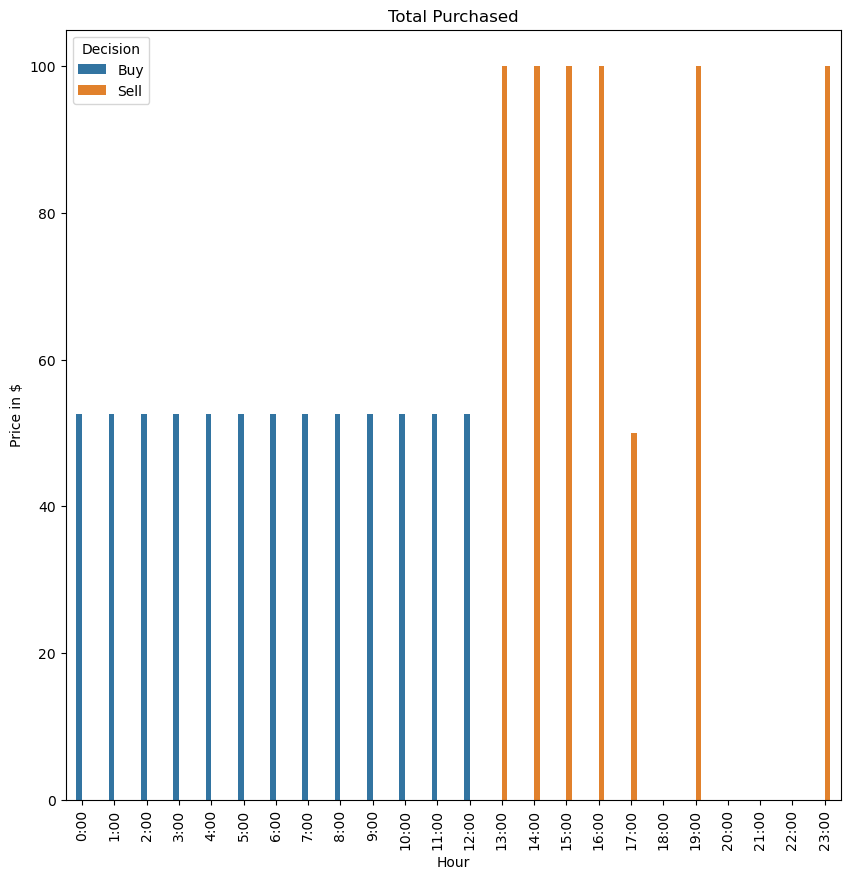

[<gurobi.Model Continuous instance ElectricityArbitrage: 96 constrs, 48 vars, No parameter changes>,
 {(0, 0): <gurobi.Var Buy[0,0] (value 52.631578947368425)>,
  (1, 0): <gurobi.Var Buy[1,0] (value 52.631578947368425)>,
  (2, 0): <gurobi.Var Buy[2,0] (value 52.631578947368425)>,
  (3, 0): <gurobi.Var Buy[3,0] (value 52.631578947368425)>,
  (4, 0): <gurobi.Var Buy[4,0] (value 52.631578947368425)>,
  (5, 0): <gurobi.Var Buy[5,0] (value 52.631578947368425)>,
  (6, 0): <gurobi.Var Buy[6,0] (value 52.631578947368425)>,
  (7, 0): <gurobi.Var Buy[7,0] (value 52.631578947368425)>,
  (8, 0): <gurobi.Var Buy[8,0] (value 52.631578947368425)>,
  (9, 0): <gurobi.Var Buy[9,0] (value 52.631578947368425)>,
  (10, 0): <gurobi.Var Buy[10,0] (value 52.631578947368425)>,
  (11, 0): <gurobi.Var Buy[11,0] (value 52.631578947368425)>,
  (12, 0): <gurobi.Var Buy[12,0] (value 52.631578947368425)>,
  (13, 0): <gurobi.Var Buy[13,0] (value 0.0)>,
  (14, 0): <gurobi.Var Buy[14,0] (value 0.0)>,
  (15, 0): <gurobi.

In [27]:
run(parameters)